In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Pregnancy During the COVID-19 Pandemic.csv", sep=None, engine="python")
df.columns = df.columns.str.strip().str.replace(" ", "_")
# print(df.head())
print(df.columns.tolist())

['OSF_ID', 'Maternal_Age', 'Household_Income', 'Maternal_Education', 'Edinburgh_Postnatal_Depression_Scale', 'PROMIS_Anxiety', 'Gestational_Age_At_Birth', 'Delivery_Date(converted_to_month_and_year)', 'Birth_Length', 'Birth_Weight', 'Delivery_Mode', 'NICU_Stay', 'Language', 'Threaten_Life', 'Threaten_Baby_Danger', 'Threaten_Baby_Harm']


In [3]:
print(df.info())
# df.isnull().sum()
# df.describe()
# df.shape
# df.duplicated().sum()
# df.unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10772 entries, 0 to 10771
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   OSF_ID                                      10772 non-null  int64  
 1   Maternal_Age                                10661 non-null  float64
 2   Household_Income                            10521 non-null  object 
 3   Maternal_Education                          10595 non-null  object 
 4   Edinburgh_Postnatal_Depression_Scale        9598 non-null   float64
 5   PROMIS_Anxiety                              9566 non-null   float64
 6   Gestational_Age_At_Birth                    6734 non-null   float64
 7   Delivery_Date(converted_to_month_and_year)  6733 non-null   object 
 8   Birth_Length                                5480 non-null   float64
 9   Birth_Weight                                6078 non-null   float64
 10  Delivery_M

In [4]:
# Cleaning Household_Income Column
# Function to clean each cell
def clean_income(cell):
    if pd.isna(cell):   # if value is NaN
        return None
    # Remove words like "Less than", "$", ",", "+", and extra spaces
    cell = (cell.replace("Less than", "")
                 .replace("$", "")
                 .replace(",", "")
                 .replace("+", "")
                 .replace(" ", "")  # <--- remove spaces inside numbers
                 .strip())
    # if it's a range, take average
    if "-" in cell:
        low, high = cell.split("-")
        low = int(low.strip())
        high = int(high.strip())
        return (low + high) / 2
    else:
        return int(cell)

# Apply function → create new column
df["Income_Cleaned"] = df["Household_Income"].apply(clean_income)

# print(df["Income_Cleaned"])
# df.isnull().sum()
# (df.isnull().sum() / len(df)) * 100
# df.info()

In [5]:
import numpy as np

# Handling Data Type for Income_Cleaned
df["Income_Cleaned"].isnull().sum()

def suggest_imputation(df, column):
    """
    Takes a dataframe and a column name,
    calculates skewness and suggests mean or median for missing value handling.
    """
    if column not in df.columns:
        return f"Column '{column}' not found in DataFrame."
    
    if not np.issubdtype(df[column].dtype, np.number):
        return f"Column '{column}' is not numeric. Cannot calculate skewness."

    skew = df[column].skew()

    if -0.5 <= skew <= 0.5:
        return f"{column}: skew = {skew:.2f} → Nearly symmetric → Suggest **MEAN**"
    elif skew > 0.5:
        return f"{column}: skew = {skew:.2f} → Right skew → Suggest **MEDIAN**"
    else:  # skew < -0.5
        return f"{column}: skew = {skew:.2f} → Left skew → Suggest **MEDIAN**"

suggest_imputation(df, "Income_Cleaned")

'Income_Cleaned: skew = 0.10 → Nearly symmetric → Suggest **MEAN**'

In [6]:
df["Income_Cleaned"] = df["Income_Cleaned"].fillna(df["Income_Cleaned"].mean())
df['Income_Cleaned'].isnull().sum()


np.int64(0)

In [7]:
# reload fresh DataFrame
df = pd.read_csv("Pregnancy_Cleaned.csv")
df["Household_Income"] = df["Income_Cleaned"].fillna(0).astype(int)
# df.to_csv("Pregnancy_Cleaned.csv", index=False)


In [8]:
def detect_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {len(outliers)} outliers found")

# Example usage
detect_outliers_iqr(df)


OSF_ID: 0 outliers found
Maternal_Age: 98 outliers found
Household_Income: 0 outliers found
Edinburgh_Postnatal_Depression_Scale: 20 outliers found
PROMIS_Anxiety: 0 outliers found
Gestational_Age_At_Birth: 171 outliers found
Birth_Length: 225 outliers found
Birth_Weight: 145 outliers found
Income_Cleaned: 0 outliers found


In [9]:
df["Maternal_Age"] = df["Maternal_Age"].fillna(df["Maternal_Age"].mean())
df["Maternal_Age"].isnull().sum()


# df["Maternal_Education"].mode() # most frequent value will be return also when use [0]
df["Maternal_Education"] = df["Maternal_Education"].fillna("Unknown")
df["Maternal_Education"].isnull().sum()

edu_order = {
    "Less than high school diploma": 0,
    "High school diploma": 1,
    "College/trade school": 2,
    "Undergraduate degree": 3,
    "Masters degree": 4,
    "Doctoral Degree": 5,
    "Unknown": -1   # separate code for missing/unknown
}

df["Maternal_Education_encoded"] = df["Maternal_Education"].map(edu_order)
print(df["Maternal_Education"].unique().tolist())

df["Edinburgh_Postnatal_Depression_Scale"] = df["Edinburgh_Postnatal_Depression_Scale"].fillna(df["Edinburgh_Postnatal_Depression_Scale"].mean())
df["Edinburgh_Postnatal_Depression_Scale"].isnull().sum()

df["Edinburgh_Postnatal_Depression_Scale"] = df["Edinburgh_Postnatal_Depression_Scale"].round().astype("Int64")
df["Edinburgh_Postnatal_Depression_Scale"].unique().tolist()

df["PROMIS_Anxiety"] = df["PROMIS_Anxiety"].fillna(df["PROMIS_Anxiety"].mean())
df["PROMIS_Anxiety"] = df["PROMIS_Anxiety"].round().astype("Int64")

# df["Gestational_Age_At_Birth"].unique().tolist()
# print(df["Gestational_Age_At_Birth"].value_counts()[39.14])
df["Gestational_Age_At_Birth"] = df["Gestational_Age_At_Birth"].fillna(df["Gestational_Age_At_Birth"].median())
df["Gestational_Age_At_Birth"] = df["Gestational_Age_At_Birth"].round().astype("Int64")
df.isnull().sum()



['Masters degree', 'Undergraduate degree', 'High school diploma', 'Unknown', 'College/trade school', 'Less than high school diploma', 'Doctoral Degree']


OSF_ID                                           0
Maternal_Age                                     0
Household_Income                                 0
Maternal_Education                               0
Edinburgh_Postnatal_Depression_Scale             0
PROMIS_Anxiety                                   0
Gestational_Age_At_Birth                         0
Delivery_Date(converted_to_month_and_year)    4039
Birth_Length                                  5292
Birth_Weight                                  4694
Delivery_Mode                                 5235
NICU_Stay                                     5238
Language                                         0
Threaten_Life                                    0
Threaten_Baby_Danger                             0
Threaten_Baby_Harm                               0
Income_Cleaned                                   0
Maternal_Education_encoded                       0
dtype: int64

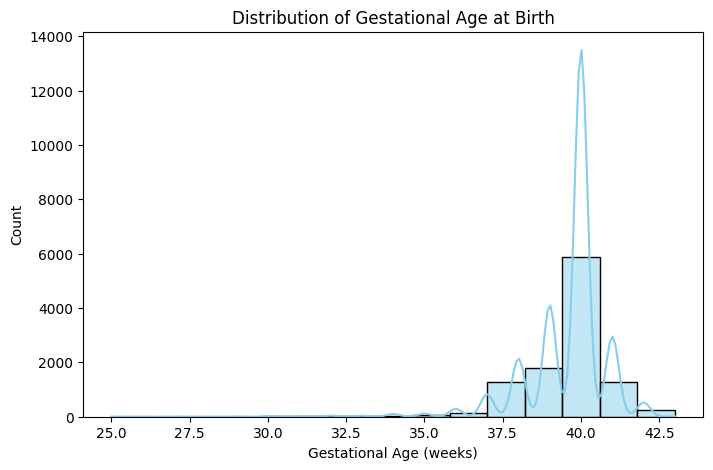

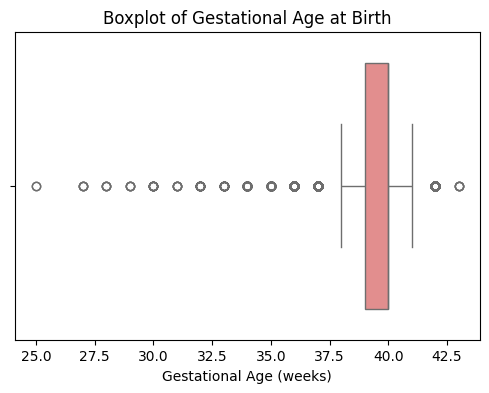

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df["Gestational_Age_At_Birth"], bins=15, kde=True, color="skyblue")
plt.title("Distribution of Gestational Age at Birth")
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Gestational_Age_At_Birth"], color="lightcoral")
plt.title("Boxplot of Gestational Age at Birth")
plt.xlabel("Gestational Age (weeks)")
plt.show()


In [11]:
df["Delivery_Date(converted_to_month_and_year)"].unique()
# Example: extract year and month
df["Delivery_Date"] = df["Delivery_Date(converted_to_month_and_year)"]

# Split into Year and Month
df[["Year", "Month"]] = df["Delivery_Date"].str.split("-", expand=True)

# Convert year to full year (20 → 2020, etc.)
df["Year"] = df["Year"].astype(float) + 2000

# Map month names to numbers
month_map = {"Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6,
             "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
df["Month"] = df["Month"].map(month_map)
df["Month"]


# # Handle missing values → fill with mode or "Unknown"
df["Year"] = df["Year"].fillna(df["Year"].mode()[0])
df["Month"] = df["Month"].fillna(df["Month"].mode()[0])

df["Month"] = df["Month"].round().astype("Int64")
df["Year"] = df["Year"].round().astype("Int64")

print(df[["Delivery_Date", "Year", "Month"]].head())


  Delivery_Date  Year  Month
0        20-Dec  2020     12
1           NaN  2020      7
2           NaN  2020      7
3        20-Dec  2020     12
4        20-Oct  2020     10


In [12]:
def value_counts_with_percent(df, column):
    """
    Takes a DataFrame and column name,
    returns value counts with percentage.
    """
    if column not in df.columns:
        return f" Column '{column}' not found."

    counts = df[column].value_counts(dropna=False)  # keep NaN if present
    perc = df[column].value_counts(normalize=True, dropna=False) * 100

    result = pd.DataFrame({
        "Count": counts,
        "Percentage": perc.round(2)
    })

    return result
# value_counts_with_percent(df, "Month")


In [13]:
df.isnull().sum()
df["Birth_Length"] = df["Birth_Length"].fillna(df["Birth_Length"].median())
# df["Birth_Length"].isnull().sum()
# df["Birth_Length"].sort_values(ascending=False).head(10)
# df["Birth_Length"].unique().tolist()


In [14]:
# Hanling Outliers for Birth Length:
lower, upper = 30, 60  

# Option 1: Cap values (keep row but limit extremes)
df["Birth_Length"] = df["Birth_Length"].clip(lower, upper)

# Option 2: Drop invalid values
df = df[(df["Birth_Length"] >= lower) & (df["Birth_Length"] <= upper)]

In [15]:
def detect_outliers_iqr(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        print(f"{col}: {len(outliers)} outliers found")

# Example usage
detect_outliers_iqr(df)


OSF_ID: 0 outliers found
Maternal_Age: 109 outliers found
Household_Income: 0 outliers found
Edinburgh_Postnatal_Depression_Scale: 166 outliers found
PROMIS_Anxiety: 0 outliers found
Gestational_Age_At_Birth: 870 outliers found
Birth_Length: 4496 outliers found
Birth_Weight: 145 outliers found
Income_Cleaned: 0 outliers found
Maternal_Education_encoded: 1105 outliers found
Year: 2549 outliers found
Month: 1139 outliers found


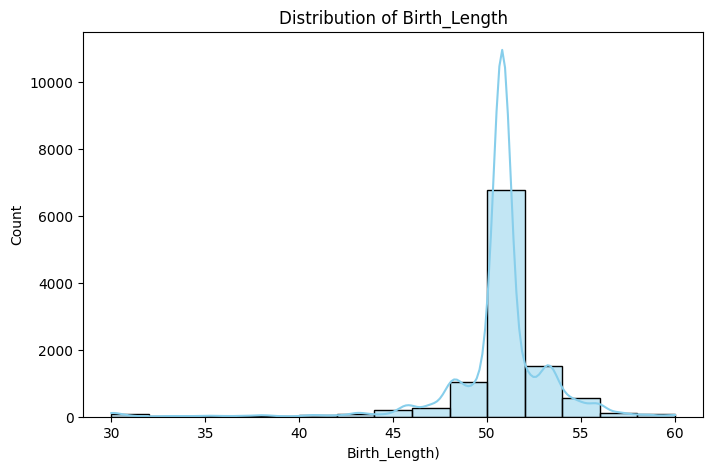

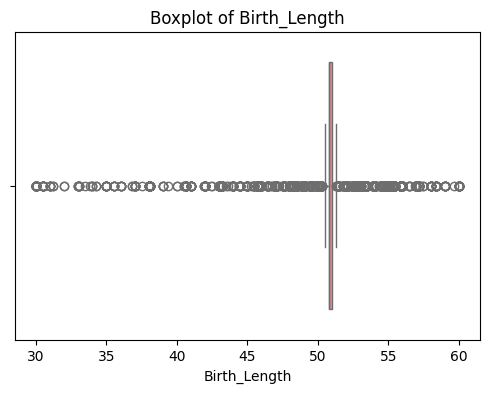

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(df["Birth_Length"], bins=15, kde=True, color="skyblue")
plt.title("Distribution of Birth_Length")
plt.xlabel("Birth_Length)")
plt.ylabel("Count")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Birth_Length"], color="lightcoral")
plt.title("Boxplot of Birth_Length")
plt.xlabel("Birth_Length")
plt.show()


In [17]:
df["Birth_Weight"] = df["Birth_Weight"].fillna(df["Birth_Weight"].median())

In [18]:
# Handling Outlier for Birth Weight
# Hanling Outliers for Birth Length:
lower, upper = 1000, 5000  

# Option 1: Cap values (keep row but limit extremes)
df["Birth_Weight"] = df["Birth_Weight"].clip(lower, upper)

# Option 2: Drop invalid values
df = df[(df["Birth_Weight"] >= lower) & (df["Birth_Weight"] <= upper)]
# df["Birth_Weight"].sort_values(ascending=False).head(10)
df.columns.tolist()

['OSF_ID',
 'Maternal_Age',
 'Household_Income',
 'Maternal_Education',
 'Edinburgh_Postnatal_Depression_Scale',
 'PROMIS_Anxiety',
 'Gestational_Age_At_Birth',
 'Delivery_Date(converted_to_month_and_year)',
 'Birth_Length',
 'Birth_Weight',
 'Delivery_Mode',
 'NICU_Stay',
 'Language',
 'Threaten_Life',
 'Threaten_Baby_Danger',
 'Threaten_Baby_Harm',
 'Income_Cleaned',
 'Maternal_Education_encoded',
 'Delivery_Date',
 'Year',
 'Month']

In [19]:
df["Delivery_Mode"].mode()[0]
# (.isnull().sum() * len(df)) / 100
(df['Delivery_Mode'].isnull().sum() / len(df)) * 100


np.float64(48.59821760118827)

In [20]:
# General Forumula when to use Unknown???
# if missing_percentage < 10%:
#     use Mode
# elif 10% <= missing_percentage <= 40%:
#     if missing seems random:
#         use Mode
#     else:
#         use "Unknown"
# else:   # >40%
#     use "Unknown"


In [21]:
df["Delivery_Mode"] = df["Delivery_Mode"].fillna("Unknown")
(df['Delivery_Mode'].isnull().sum() / len(df)) * 100
# df["Delivery_Mode"].unique().tolist()
df["Delivery_Mode_Original"] = df["Delivery_Mode"]   # backup copy
df = pd.get_dummies(df, columns=["Delivery_Mode"], prefix="DeliveryMode")
df["Delivery_Mode_Original"]
df.head()

,OSF_ID,Maternal_Age,Household_Income,Maternal_Education,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Delivery_Date(converted_to_month_and_year),Birth_Length,Birth_Weight,...,Threaten_Baby_Harm,Income_Cleaned,Maternal_Education_encoded,Delivery_Date,Year,Month,Delivery_Mode_Original,DeliveryMode_Caesarean-section (c-section),DeliveryMode_Unknown,DeliveryMode_Vaginally
0,1,38.3,200000,Masters degree,9,13,40,20-Dec,49.20,3431.0,...,27,200000.0,4,20-Dec,2020,12,Vaginally,False,False,True
1,2,34.6,200000,Undergraduate degree,4,17,40,NaN,50.80,3431.0,...,92,200000.0,3,NaN,2020,7,Unknown,False,True,False
2,3,34.3,112499,Undergraduate degree,10,19,40,NaN,50.80,3431.0,...,,112499.5,3,NaN,2020,7,Unknown,False,True,False
3,4,28.8,112499,Masters degree,9,20,39,20-Dec,41.00,2534.0,...,54,112499.5,4,20-Dec,2020,12,Vaginally,False,False,True
4,5,36.5,54999,Undergraduate degree,14,20,40,20-Oct,53.34,3714.0,...,71,54999.5,3,20-Oct,2020,10,Caesarean-section (c-section),True,False,False


In [22]:
#  7   Language                                    10772 non-null  object 
#  8   Threaten_Life                               10772 non-null  object 
#  9   Threaten_Baby_Danger                        10772 non-null  object 
#  10  Threaten_Baby_Harm                          10772 non-null  object 
df["Language"].mode
df["Language"] = df["Language"].fillna(df["Language"].mode()[0])
df["Language_mapped"] = df["Language"].map({"English": 1, "French": 0})

df['Language_mapped'].unique().tolist()


[1, 0]

In [23]:
# (df['NICU_Stay'].isnull().sum() / len(df)) * 100

# Example: Assume NICU_Stay has Yes / No / NaN
df['NICU_missing_flag'] = df['NICU_Stay'].isna().astype(int)

# Replace NaN with "No"
df['NICU_Stay_filled'] = df['NICU_Stay'].fillna("No")


# Map Yes = 1, No = 0
df["NICU_Stay_Orignal_mapped"] = df["NICU_Stay_filled"].map({"Yes": 1, "No": 0})
df['NICU_Stay_Orignal_mapped'].unique().tolist()


[0, 1]

In [24]:
# cols_to_convert = ["Threaten_Life", "Threaten_Baby_Danger", "Threaten_Baby_Harm"]

# df[cols_to_convert] = df[cols_to_convert].astype('int64')
# df['Threaten_Life'] = df['Threaten_Life'].astype('int64')


# Replace blank spaces or empty strings with NaN
df['Threaten_Life'] = df['Threaten_Life'].replace(r'^\s*$', pd.NA, regex=True)
df['Threaten_Baby_Danger'] = df['Threaten_Baby_Danger'].replace(r'^\s*$', pd.NA, regex=True)
df['Threaten_Baby_Harm'] = df['Threaten_Baby_Harm'].replace(r'^\s*$', pd.NA, regex=True)

# Convert to numeric, forcing invalid values to NaN
df['Threaten_Life'] = pd.to_numeric(df['Threaten_Life'], errors='coerce')
df['Threaten_Baby_Danger'] = pd.to_numeric(df['Threaten_Baby_Danger'], errors='coerce')
df['Threaten_Baby_Harm'] = pd.to_numeric(df['Threaten_Baby_Harm'], errors='coerce')

df['Threaten_Life'].unique()
df["Threaten_Life"] = df["Threaten_Life"].fillna(df["Threaten_Life"].mean())
df["Threaten_Baby_Danger"] = df["Threaten_Baby_Danger"].fillna(df["Threaten_Baby_Danger"].mean())
df["Threaten_Baby_Harm"] = df["Threaten_Baby_Harm"].fillna(df["Threaten_Baby_Harm"].mean())


df['Threaten_Life'] = df['Threaten_Life'].astype('int64')
df['Threaten_Baby_Danger'] = df['Threaten_Baby_Danger'].astype('int64')
df['Threaten_Baby_Harm'] = df['Threaten_Baby_Harm'].astype('int64')

# print(df['Threaten_Life'].dtype)
# print(df['Threaten_Baby_Danger'].dtype)
# print(df['Threaten_Baby_Harm'].dtype)

df.columns.tolist()



['OSF_ID',
 'Maternal_Age',
 'Household_Income',
 'Maternal_Education',
 'Edinburgh_Postnatal_Depression_Scale',
 'PROMIS_Anxiety',
 'Gestational_Age_At_Birth',
 'Delivery_Date(converted_to_month_and_year)',
 'Birth_Length',
 'Birth_Weight',
 'NICU_Stay',
 'Language',
 'Threaten_Life',
 'Threaten_Baby_Danger',
 'Threaten_Baby_Harm',
 'Income_Cleaned',
 'Maternal_Education_encoded',
 'Delivery_Date',
 'Year',
 'Month',
 'Delivery_Mode_Original',
 'DeliveryMode_Caesarean-section (c-section)',
 'DeliveryMode_Unknown',
 'DeliveryMode_Vaginally',
 'Language_mapped',
 'NICU_missing_flag',
 'NICU_Stay_filled',
 'NICU_Stay_Orignal_mapped']

In [25]:
df.columns.tolist()
drop_cols = [
    'OSF_ID',
    'Household_Income',
    'Maternal_Education',
    'Delivery_Date',
    'Delivery_Date(converted_to_month_and_year)',
    'Delivery_Mode_Original',
    'Language',
    'NICU_Stay',
    'NICU_Stay_filled'
]
df_cleaned = df.drop(columns=drop_cols)
df_cleaned.isnull().sum()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10772 entries, 0 to 10771
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Maternal_Age                                10772 non-null  float64
 1   Edinburgh_Postnatal_Depression_Scale        10772 non-null  Int64  
 2   PROMIS_Anxiety                              10772 non-null  Int64  
 3   Gestational_Age_At_Birth                    10772 non-null  Int64  
 4   Birth_Length                                10772 non-null  float64
 5   Birth_Weight                                10772 non-null  float64
 6   Threaten_Life                               10772 non-null  int64  
 7   Threaten_Baby_Danger                        10772 non-null  int64  
 8   Threaten_Baby_Harm                          10772 non-null  int64  
 9   Income_Cleaned                              10772 non-null  float64
 10  Maternal_E

In [26]:
df_cleaned.head(5)

,Maternal_Age,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,Income_Cleaned,Maternal_Education_encoded,Year,Month,DeliveryMode_Caesarean-section (c-section),DeliveryMode_Unknown,DeliveryMode_Vaginally,Language_mapped,NICU_missing_flag,NICU_Stay_Orignal_mapped
0,38.3,9,13,40,49.20,3431.0,2,3,27,200000.0,4,2020,12,False,False,True,1,0,0
1,34.6,4,17,40,50.80,3431.0,2,33,92,200000.0,3,2020,7,False,True,False,1,1,0
2,34.3,10,19,40,50.80,3431.0,42,50,62,112499.5,3,2020,7,False,True,False,0,1,0
3,28.8,9,20,39,41.00,2534.0,53,67,54,112499.5,4,2020,12,False,False,True,0,0,0
4,36.5,14,20,40,53.34,3714.0,23,32,71,54999.5,3,2020,10,True,False,False,1,0,0


In [27]:
from sklearn.preprocessing import StandardScaler

# columns to scale
cols_to_scale = [
    "Maternal_Age", "Edinburgh_Postnatal_Depression_Scale",
    "PROMIS_Anxiety", "Gestational_Age_At_Birth",
    "Birth_Length", "Birth_Weight", "Income_Cleaned"
]

scaler = StandardScaler()
df_cleaned[cols_to_scale] = scaler.fit_transform(df_cleaned[cols_to_scale])
df_cleaned.describe()


,Maternal_Age,Edinburgh_Postnatal_Depression_Scale,PROMIS_Anxiety,Gestational_Age_At_Birth,Birth_Length,Birth_Weight,Threaten_Life,Threaten_Baby_Danger,Threaten_Baby_Harm,Income_Cleaned,Maternal_Education_encoded,Year,Month,Language_mapped,NICU_missing_flag,NICU_Stay_Orignal_mapped
count,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,1.077200e+04,10772.000000,10772.000000,10772.000000,1.077200e+04,10772.000000,10772.0,10772.0,10772.000000,10772.000000,10772.000000
mean,-2.678057e-16,-9.498529e-17,-9.762377e-17,-1.373329e-15,-1.365414e-15,-5.105459e-16,42.313591,50.776272,62.381359,7.255821e-17,2.792518,2020.238489,6.981619,0.757055,0.486261,0.050873
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,24.550817,25.508668,26.083675,1.000046e+00,1.181798,0.430514,2.415951,0.428882,0.499834,0.219748
min,-3.374297e+00,-1.957717e+00,-2.042789e+00,-1.092651e+01,-6.938682e+00,-6.065462e+00,0.000000,0.000000,0.000000,-1.847307e+00,-1.000000,2020.0,1.0,0.000000,0.000000,0.000000
25%,-6.466007e-01,-6.106990e-01,-6.476552e-01,-4.330078e-01,4.761967e-02,-1.167142e-01,25.000000,31.000000,49.000000,-5.675606e-01,2.000000,2020.0,6.0,1.000000,0.000000,0.000000
50%,-1.013835e-02,-3.340570e-02,4.991179e-02,3.165278e-01,4.761967e-02,2.611587e-02,42.000000,50.000000,62.000000,-2.612534e-02,3.000000,2020.0,7.0,1.000000,0.000000,0.000000
75%,6.717856e-01,5.438876e-01,7.474788e-01,3.165278e-01,1.147956e-01,1.664402e-01,58.000000,70.000000,82.000000,9.583024e-01,3.000000,2020.0,8.0,1.000000,1.000000,0.000000
max,4.058675e+00,3.815217e+00,2.840180e+00,2.565134e+00,3.137714e+00,3.957702e+00,100.000000,100.000000,100.000000,1.696633e+00,5.000000,2022.0,12.0,1.000000,1.000000,1.000000


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = df_cleaned.drop("NICU_Stay_Orignal_mapped", axis=1)
y = df_cleaned["NICU_Stay_Orignal_mapped"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)
X.columns.tolist()

['Maternal_Age',
 'Edinburgh_Postnatal_Depression_Scale',
 'PROMIS_Anxiety',
 'Gestational_Age_At_Birth',
 'Birth_Length',
 'Birth_Weight',
 'Threaten_Life',
 'Threaten_Baby_Danger',
 'Threaten_Baby_Harm',
 'Income_Cleaned',
 'Maternal_Education_encoded',
 'Year',
 'Month',
 'DeliveryMode_Caesarean-section (c-section)',
 'DeliveryMode_Unknown',
 'DeliveryMode_Vaginally',
 'Language_mapped',
 'NICU_missing_flag']

In [29]:
y_pred = model.predict(X_test)


In [30]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9596287703016241
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2045
           1       0.93      0.23      0.36       110

    accuracy                           0.96      2155
   macro avg       0.94      0.61      0.67      2155
weighted avg       0.96      0.96      0.95      2155

[[2043    2]
 [  85   25]]


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9596287703016241
Precision: 0.9259259259259259
Recall: 0.22727272727272727
F1 Score: 0.36496350364963503


In [32]:
import json

metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

with open("metrics.json", "w") as f:
    json.dump(metrics, f)


In [33]:
import pandas as pd
import joblib

joblib.dump(model, "Pragnancy_NICU_model.pkl")
joblib.dump(scaler, "scaler.pkl")




['scaler.pkl']

In [34]:
from sklearn.preprocessing import StandardScaler

# Load your trained model
model = joblib.load("Pragnancy_NICU_model.pkl")
scaler = joblib.load("scaler.pkl")

In [35]:
# ------------------------------
# Example dictionary (replace with real input values)
# ------------------------------
example = {
    "Maternal_Age": 19,   # younger age (risk factor)
    "Edinburgh_Postnatal_Depression_Scale": 20,  # high depression score
    "PROMIS_Anxiety": 25,  # high anxiety
    "Gestational_Age_At_Birth": 33,  # preterm (<37 weeks)
    "Birth_Length": 42,   # shorter than average
    "Birth_Weight": 1800,  # low birth weight
    "Threaten_Life": 1,   # yes
    "Threaten_Baby_Danger": 1,  # yes
    "Threaten_Baby_Harm": 0,
    "Income_Cleaned": 10000,  # lower income
    "Maternal_Education_encoded": 1,  # lower education
    "Year": 2023,
    "Month": 7,
    "DeliveryMode_Caesarean-section (c-section)": 1,  # C-section
    "DeliveryMode_Unknown": 0,
    "DeliveryMode_Vaginally": 0,
    "Language_mapped": 1,
    "NICU_missing_flag": 0,
}

# ------------------------------
# Convert into DataFrame
# ------------------------------
X_new = pd.DataFrame([example])

# Ensure same column order as training
X_new = X_new[model.feature_names_in_]

# ------------------------------
# Scale only the required columns
# ------------------------------
cols_to_scale = [
    "Maternal_Age", "Edinburgh_Postnatal_Depression_Scale",
    "PROMIS_Anxiety", "Gestational_Age_At_Birth",
    "Birth_Length", "Birth_Weight", "Income_Cleaned"
]

X_new[cols_to_scale] = scaler.transform(X_new[cols_to_scale])

# ------------------------------
# Predict
# ------------------------------
pred_class = model.predict(X_new)[0]
pred_prob  = model.predict_proba(X_new)[0]

print("Predicted NICU Stay class:", pred_class)
print("Predicted probabilities:", pred_prob)


Predicted NICU Stay class: 1
Predicted probabilities: [0.20917081 0.79082919]
